# Discrete Fréchet Distance - Recursive or Linear?
This notebook presents two alternative implementations of the discrete Fréchet distance calculation. The first implementation is the recursive version as proposed by Eiter an Mannila. The second implementation is linear and emerged as an insight from the first.

We start by importing the required Python packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from distances.discrete import euclidean
from typing import Callable
from numba import jit

Now we define the sample poly-lines for later use. These live in R<sup>2</sup> and we will use the euclidean distance to measure pointwise distances.

In [2]:
p = np.array([[0.2, 2.0], 
              [1.5, 2.8], 
              [2.3, 1.6], 
              [2.9, 1.8], 
              [4.1, 3.1], 
              [5.6, 2.9], 
              [7.2, 1.3],
              [8.2, 1.1]])

In [3]:
q = np.array([[0.3, 1.6], 
              [3.2, 3.0], 
              [3.8, 1.8],  
              [5.2, 3.1], 
              [6.5, 2.8], 
              [7.0, 0.8],
              [8.9, 0.6]])

## Recursive Implementation
Below is the recursive implementation of the discrete Fréchet distance. The `recursive_frechet` sets up a few global variables and then calls the `calculate` function. This function calls itself in five different locations. Following the return order of matrix indices, you can see that they are being generated in a sequential fashion: column first, then row. This is a great hint to improve on this algorithm with a sequential (non-recursive) one.

**Note**: the `@jit` annotations enable the Numba just-in-time compiler. When measuring performance of this code, always account for the initial compilation that makes the code run slightly slower the first time.

In [4]:
@jit(nopython=True)
def calculate(ca: np.ndarray, i: int, j: int, dist_func: Callable[[np.ndarray, np.ndarray], float]) -> float:
    """
    Calculates the distance between p[i] and q[i]
    :param i: Index into poly-line p
    :param j: Index into poly-line q
    :return: Distance value
    """
    if ca[i, j] > -1.0:
        # Uncomment the line below to see when the code does the dynamic programming trick: reuses already-calculated values
        # print(i, j, "*")
        return ca[i, j]

    # Uncomment the line below to follow the order of recursive calls
    # print(i, j)
    d = dist_func(p[i], q[j])
    if i > 0 and j > 0:
        ca[i, j] = max(min(calculate(ca, i-1, j, dist_func),
                           calculate(ca, i-1, j-1, dist_func),
                           calculate(ca, i, j-1, dist_func)), d)
    elif i > 0 and j == 0:
        ca[i, j] = max(calculate(ca, i-1, 0, dist_func), d)
    elif i == 0 and j > 0:
        ca[i, j] = max(calculate(ca, 0, j-1, dist_func), d)
    else:
        ca[i, j] = d

    # Uncomment the line below to follow the return order of the calculated values.
    # print(i, j)
    # This is how the order of the returned coordinates was calculated in the Medium article.
    return ca[i, j]


@jit(nopython=True)
def recursive_frechet_calculator(p: np.ndarray, q: np.ndarray, dist_func: Callable[[np.ndarray, np.ndarray], float]) -> (float, np.ndarray):
    """
    Calculates the Fréchet distance between poly-lines p and q
    This function implements the algorithm described by Eiter & Mannila
    :param p: Poly-line p
    :param q: Poly-line q
    :return: Distance value
    """
    n_p = p.shape[0]
    n_q = q.shape[0]
    ca = np.zeros((n_p, n_q), dtype=np.float64)
    ca.fill(-1.0)
    return calculate(ca, n_p - 1, n_q - 1, dist_func), ca


@jit(nopython=True)
def recursive_frechet(p: np.ndarray, q: np.ndarray, dist_func: Callable[[np.ndarray, np.ndarray], float]) -> float:
    d, ca = recursive_frechet_calculator(p, q, dist_func)
    return d


@jit(nopython=True)
def recursive_frechet_diag(p: np.ndarray, q: np.ndarray, dist_func: Callable[[np.ndarray, np.ndarray], float]) -> float:
    d, ca = recursive_frechet_calculator(p, q, dist_func)
    return ca

Use the cell below to execute or time the recursive call. Uncomment the first line to time the call, and remember to run it twice!

In [15]:
%%timeit
recursive_frechet(p, q, euclidean)

18.5 µs ± 721 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## The Free-Space Diagram
The free-space diagram shows all cells whose values are below a given ∂.

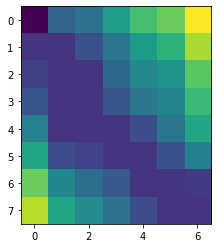

In [7]:
fsd = recursive_frechet_diag(p, q, euclidean)
plt.imshow(fsd)

The above image displays a fairly typical free-space diagram. When curves are similar, the smallest values will lie along the diagonal and the discrete Fréchet distance between both curves is at the bottom-right corner of the matrix.

In [9]:
np.set_printoptions(precision=4)
fsd

array([[0.4123, 3.1623, 3.6056, 5.1196, 6.3506, 6.9051, 8.8119],
       [1.6971, 1.7117, 2.508 , 3.7121, 5.    , 5.8523, 7.7201],
       [2.    , 1.6971, 1.6971, 3.265 , 4.3681, 4.7676, 6.6753],
       [2.6077, 1.6971, 1.6971, 2.642 , 3.7363, 4.2202, 6.1188],
       [4.0853, 1.6971, 1.6971, 1.6971, 2.4187, 3.7014, 5.412 ],
       [5.4571, 2.4021, 2.1095, 1.6971, 1.6971, 2.5239, 4.0224],
       [6.9065, 4.3463, 3.4366, 2.6907, 1.6971, 1.6971, 1.8385],
       [7.9158, 5.3488, 4.4553, 3.6056, 2.4042, 1.6971, 1.6971]])

## Linear Implementation
The linear implementation uses two simple nested loops to do its job. This insight was drawn by studying how the recursive version works, and leads to a slightly better runtime and much improved call stack usage.

In [12]:
@jit(nopython=True)
def linear_frechet(p: np.ndarray, q: np.ndarray, dist_func: Callable[[np.ndarray, np.ndarray], float]) -> float:
    n_p = p.shape[0]
    n_q = q.shape[0]
    ca = np.zeros((n_p, n_q), dtype=np.float64)

    for i in range(n_p):
        for j in range(n_q):
            d = dist_func(p[i], q[j])

            if i > 0 and j > 0:
                ca[i, j] = max(min(ca[i - 1, j],
                                   ca[i - 1, j - 1],
                                   ca[i, j - 1]), d)
            elif i > 0 and j == 0:
                ca[i, j] = max(ca[i - 1, 0], d)
            elif i == 0 and j > 0:
                ca[i, j] = max(ca[0, j - 1], d)
            else:
                ca[i, j] = d
    return ca[n_p - 1, n_q - 1]

Same as before, for the linear implementation.

In [16]:
%%timeit
linear_frechet(p, q, euclidean)

17.6 µs ± 257 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


There is still room for improvement as we will see in another notebook. When calculating large polylines, most of the distance matrix is actually useless to calculate the implicit free-space diagram. Removing these distance calculations will further improve the calculation performance.